# NN Walkthrough

In this notebook we will walk through the forward and backward direction of neural networks.

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import seaborn as sns

# for creating animations
import matplotlib.animation
from IPython.display import HTML

In [2]:
# styling additions
from IPython.display import HTML
# style = "<style>div.warn{background-color: #fcf2f2;border-color: #dFb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;}</style>"
style = "<style>div.info{padding: 15px; border: 1px solid transparent; border-left: 5px solid #dfb5b4; border-color: transparent; margin-bottom: 10px; border-radius: 4px; background-color: #fcf8e3; border-color: #faebcc;}</style>"
HTML(style)

 # Forward Direction

Lets start with the simplest network we can imagine, and first understand how a neural network calculates its output for a particular input. This is known as the "forward" direction (we will see why later). 

## Dataset

Lets generate a simple 1-D toy dataset:

In [3]:
def toy():
    N = 1000
    inputs = np.linspace(-5,5,N).reshape(N,1)
    labels = ((inputs>0).astype(int)*2-1).reshape(N,1)
    return inputs,labels

In [4]:
inputs,labels = toy()
inputs[0],labels[0]

(array([-5.]), array([-1]))

## 1-D Network

Lets give the simplest network we can imagine. One that consists of a few 1-D "layers" of size 1! We have an:
* input node/layer, 
* hidden node/layer:$h_1$, 
* another hidden node/layer $h_2$
* output node/layer. 

Networks are typically drawn with the **weights** on the wires. Our simple network can be given as:
![](figures/simple_network.png)

<div class="info">

**Note:** This is sometimes confusing, as technically its the **activations** of the previous layer that "flow" into the next layer. However, the weights are what we are tying to **learn**, and their relative **strengths** tells us something about the structure of the network.
    
</div>


Each node has an associated:
* weight
* bias
* activation function

In our example, we have $w_1,b_1,w_2,b_2,w_3,b_3$ as our **parameters** and we are using the **sigmoid** as our activation function.

The function of each node, is to apply its own weight and bias to a previous layers activation value, and then pass it through its activation function to produce its own activation. For example, $h_1$ is doing:

$$
a_1 = \sigma(w\cdot x + b)
$$

The *input* to a nodes activation function is useful to think about separately, so we can introduce an additional variable to denote it as:
$$
z_i = w\cdot x + b, \quad\quad a_1 = \sigma(z_i)
$$

So, we can describe the behavior of each of our nodes as:

![](figures/nodes.png)

### Implementation

Now we can actually implement this simple network. Lets start by recalling the sigmoid function:

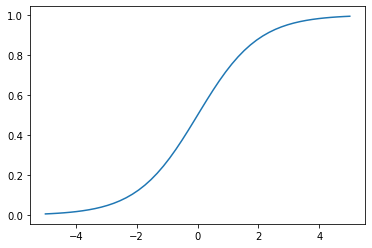

In [5]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

plt.plot(np.linspace(-5,5),sigmoid(np.linspace(-5,5)));

Lets define the function of a **node**, being careful to match our notation:

In [6]:
def node(w,b,a):
    z = w*a + b
    return sigmoid(z)

Now we are ready to define our **actual network**! Lets initialize our random weights and biases:

In [7]:
w1,b1,w2,b2,w3,b3 = np.random.rand(6)

Now, lets pick a training example and run it through our network:

In [8]:
input,label = inputs[0],labels[0]

# h1 node - operates on our input
a1 = node(w1,b1,input)

# h2 node - operates on a1
a2 = node(w2,b2,a1)

# output node - operates on a2 - produces our output
output = node(w3,b3,a2)
y_hat = output

Lets see how we did!

In [9]:
print(f"for input: {input} with label: {label}, this network calculated: {y_hat}")

for input: [-5.] with label: [-1], this network calculated: [0.68882096]


As we know, to actually see how we did, we need to **define a cost**! Lets proceed with the usual average-MSE:

In [10]:
def mse(y_hat,y,average=True):
    if average:
        return np.mean((y_hat-y)**2)
    else:
        return ((y_hat-y)**2)

In [11]:
print(f"for input: {input} with label: {label}, this network calculated: {output}, giving us a cost of: {mse(output,label)}")

for input: [-5.] with label: [-1], this network calculated: [0.68882096], giving us a cost of: 2.8521162375157307


Ok - so we've demonstrated the entire forward direction, for one sample. Lets define a function for this simple network, so we can run our entire training set through!

In [12]:
def simple_network(inputs):
    outputs = []
    N = inputs.shape[0]
    
    # initialized weights
    w1,b1,w2,b2,w3,b3 = np.random.rand(6)

    for i in range(N):
        input = inputs[i,:]
        
        # h1 node
        a1 = node(w1,b1,input)

        # h2 node
        a2 = node(w2,b2,a1)

        # output node
        output = node(w3,b3,a2)
        
        # append to form output
        outputs.append(output)
    
    return np.asarray(outputs)

We can now calculate our **average loss** over the entire training set:

In [13]:
mse(simple_network(inputs),labels)

1.696300058306274

--- 

## Multidimensional Network


We've looked at a very simple example above which captures the essence of what we are doing. However, our networks are really never actually composed of layers with one element each. Instead, **each** layer has **multiple** nodes. 

Technically, we could continue in the same way as above and individually number our weights and biases but this quickly gets out of hand! As an exercise, try repeating the above analysis and implementation where each hidden layer is now of size 2!

Ironically, to avoid this notational complexity, it seems like we must introduce additional notation, and rewrite our problem in the language of **linear algebra**. 

To introduce this notation, lets imagine a network the following structure:
![](figures/md-1.png)

To make our analysis simpler, lets zoom in on node node, and all of its input weights:

![](figures/md-2.png)

We've highlighted the 0th node in our last hidden layer and all of its inputs from the previous layer in $\color{orange}{\text{orange}}$. We've also numbered each of it input nodes with their layer-specific numbering and shown them in $\color{blue}{\text{blue}}$.

We've also named each weight according to the following format:

$$
w_{\;\color{orange}{\text{current node #}} \;,\; \color{blue}{\text{incoming node #}}}
$$

This may seem a bit counter intuitive at first, as the tendency when reading from left to write is to want to write our weights as:

$$
w_{\;\color{blue}{\text{incoming node #}} \;,\; \color{orange}{\text{current node #}} }
$$

You absolutely can, but that will result in a bunch of transposes in later equations. To get rid of them now, we will number our weights as we did above. As is typically the case, people make seemingly weird/arbitrary decisions at the front to result in simplifications down the line. 

Recall, the function of a node is to apply its weight to the activation of its input/previous layer. In this case, we have three previous nodes/input nodes, so we will also write them in $\color{blue}{\text{blue}}$ to make it clear that they are coming from the previous layer. 

So our orange node is performing:

$$
\color{orange}{w}_{\color{orange}{0},\color{blue}{0}} \cdot \color{blue}{a_0} + 
\color{orange}{w}_{\color{orange}{0},\color{blue}{1}} \cdot \color{blue}{a_1} + 
\color{orange}{w}_{\color{orange}{0},\color{blue}{2}} \cdot \color{blue}{a_2} + 
\color{orange}{b_0}
$$

Already, our eyes should be screaming **dot-product**! 

### Notation

Indeed, we can form a **vector** of the <font color='blue'>**previous layer's**</font> activations as:

$$
\color{blue}{\mathbf{a}_{prev}} = 
\begin{bmatrix}
\color{blue}{a_0 \\
a_1 \\
a_2}
\end{bmatrix}
$$

and a **vector** of the 0-th neurons **weights** in the <font color="orange">**current layer**</font> as:

$$
\color{orange}{\mathbf{w}_0} = 
\begin{bmatrix}
\color{orange}{w}_{\color{orange}{0},\color{blue}{0}} \\
\color{orange}{w}_{\color{orange}{0},\color{blue}{1}} \\
\color{orange}{w}_{\color{orange}{0},\color{blue}{2}}
\end{bmatrix}
$$

where we have used color again to make it clear what layer we are talking about: the <font color='orange'>current</font> or <font color='blue'>previous</font> layer.

Then we can rewrite what our orange node is calculating as:
$$
\begin{align}
\color{orange}{z_0} &= \color{orange}{\mathbf{w}_0} \cdot \color{blue}{\mathbf{a}_{prev}} + \color{orange}{b_0} \\
\color{orange}{a_0} &= \sigma(\color{orange}{z_0})
\end{align}
$$

Well, we've managed to rewrite the activation of **one-node** in slightly better notation. But we can we do better! Lets now reason about the entire layer!

Recall, we already have a vector of the <font color='blue'>**previous layer's** </font>activations in $\color{blue}{\mathbf{a}_{prev}}$, although we never actually gave a formula for it. Based on the formula for the <font color='orange'>0th-node</font> in the <font color='orange'>current layer</font> we just gave, lets try to give a **vector** of activations for the entire <font color='orange'>**current layer**</font>. 

(Note: to prevent a color explosion, since we're talking about the current layer, I will drop orange to refer to it most places. I will keep blue to refer to the previous layer).

To simplify our analysis, lets first note that:
$$
\mathbf{a}_{curr} = 
\begin{bmatrix}
\sigma (z_0) \\
\sigma (z_1) \\
\sigma (z_2) \\
\end{bmatrix} = 
\sigma\left(\;
\begin{bmatrix}
z_0 \\
z_1 \\
z_2 \\
\end{bmatrix}\;
\right) = 
\sigma (\mathbf{z}_{curr})
$$

So, lets focus on writing a formula for the vector $\mathbf{z}_{curr}$:

$$
\mathbf{z}_{curr} = 
\begin{bmatrix}
\mathbf{w}_0 \cdot \color{blue}{\mathbf{a}_{prev}} + b_0 \\
\mathbf{w}_1 \cdot \color{blue}{\mathbf{a}_{prev}} + b_1 \\
\mathbf{w}_2 \cdot \color{blue}{\mathbf{a}_{prev}} + b_2 \\
\end{bmatrix}
$$

Lets make it a bit clearer by writing our biases for the entire layer as a separate **vector** $\mathbf{b}$:

$$
\mathbf{z}_{curr} = 
\begin{bmatrix}
\mathbf{w}_0 \cdot \color{blue}{\mathbf{a}_{prev}} \\
\mathbf{w}_1 \cdot \color{blue}{\mathbf{a}_{prev}} \\
\mathbf{w}_2 \cdot \color{blue}{\mathbf{a}_{prev}}  \\
\end{bmatrix}
+
\mathbf{b}
$$

Just like we saw when we discussed linear regression, this vector of dot products is exactly the **matrix-vector** product of the **weight matrix** and the previous layers **activation vector**!

<div class="info">

**Definition**: The current layers **weight matrix**: $\mathbf{W}$  is a matrix of $k$-many rows, and $j$-many columns, where $k$ is the number of nodes in the current layer, and $j$ is the number of nodes in the previous layer:

$$
\mathbf{W} \in \mathbb{R}^{k,j}= 
\begin{bmatrix}
\mathbf{w}_0^T \\
\mathbf{w}_1^T \\
\ldots \\
\mathbf{w}_k^T
\end{bmatrix} = 
\begin{bmatrix}
w_{0,0} & w_{0,1} & \ldots & w_{0,j} \\
\ldots \\
w_{k,0} & w_{0,1} & \ldots & w_{k,j} \\
\end{bmatrix}
$$

**Note**: each row of the weight matrix represents all inputs to a specific node in the current layer.
    
</div>

Now, we can finally write a complete linear algebraic equation for the function of a <font color="orange">current layer</font> on a <font color="blue">previous layer</font>:

$$
\begin{align}
\mathbf{z}_{curr} &= \mathbf{W}\color{blue}{\mathbf{a}_{prev}}+\mathbf{b} \\
\mathbf{a}_{curr} &= \sigma(\mathbf{z}_{curr})
\end{align}
$$

Now, neural networks do this **sequentially**, so the last piece of the puzzle is to be able to refer to a *specific layer* by number. We now introduce the final piece of notation to let us do this: a **superscript** to designate the layer number:

<div class="info">

The activation of layer $L$ is given by:
    
$$
\begin{align}
\mathbf{z}^L &= \mathbf{W}^L \mathbf{a}^{L-1}+\mathbf{b}^L \\
\mathbf{a}^L &= \sigma(\mathbf{z}^L)
\end{align}
$$

This is often written succinctly as:

$$
\boxed{\mathbf{a}^L = \sigma(\mathbf{W}\mathbf{a}^{L-1} + \mathbf{b})}
$$

where the specific $\mathbf{W},\mathbf{b}$ we are talking about is implied.
</div>

<br/>
Wow we've come a long way! We've given a very clear and succinct linear algebraic equation for the entire forward direction for a network of any number of layers and size of each layer!

Lets perform a **size sanity check**: 
* $\mathbf{W}$ is of size $k \times j$, where $j$ is the number of neurons in the previous layer. 
* $\mathbf{a}^{L-1}$ is a vector of size $j \times 1$, the activations of the previous layer. 
* Their multiplication results in a vector of size $k \times 1$, where $k$ is the number of neurons in the current layer. 
* Our bias vector is also $k \times 1$ (as we expect!). 

So everything works as expected! 

This is why we decided to write our weight matrix to be of size $k \times j$ or $\text{# neurons in prev layer} \times \text{# neurons in current layer}$ instead of the other way around. If we had, we'd need a transpose in the equation above.

---
### Implementation

Armed with our new notation, lets write an implementation of the network we gave above:

![](figures/md-1.png)

<div class="info">

🧐**Pause-and-ponder**: What should the sizes of each $W$ be for this network? Lets go through it together! 
    
</div>

Ok! Now lets implement it! 

In [14]:
inputs,labels = toy()

In [15]:
def simple_network2(inputs):
    outputs = []
    N = inputs.shape[0]
    
    # initialize weight matrices - notice the dimensions
    W_1 = np.random.randn(3,1)
    W_2 = np.random.randn(2,3)
    W_3 = np.random.randn(1,2)
    
    # and our biases
    b_1 = np.random.randn(3,1)
    b_2 = np.random.randn(2,1)
    b_3 = np.random.randn(1,1)
    
    # loop through training data
    for i in range(N):
        
        # correct size for current input
        input = inputs[i,:]
        
        # layer 1
        a_1 = sigmoid(W_1*input + b_1)

        # layer 2
        a_2 = sigmoid(W_2.dot(a_1)+b_2)

        # output layer
        output = sigmoid(W_3.dot(a_2)+b_3)
        
        # append to form output
        outputs.append(output)
    
    return np.squeeze(np.asarray(outputs)).reshape(-1,1)

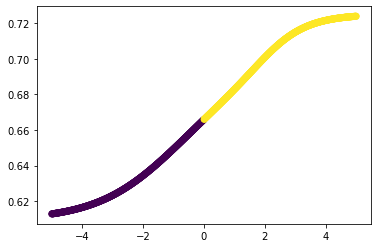

In [16]:
outputs = simple_network2(inputs)
plt.scatter(inputs,outputs,c=labels);

## Mini-Batch Notation

Note, this implementation runs an example through the network **one-by-one**! Instead, we can imagine feeding our entire dataset through **at once**! This formalism will pave the way for us later to feed in a mini-batch at a time.

Lets just reason our way through this one from **first-principles** (fancy way to say: **lets match our matrix sizes!**), seeing how we get our entire dataset through the first hidden layer. 

The first weight matrix is of size:

$$
\mathbf{W}_1: (\text{size of hidden layer} \times \text{dimension of input})
$$

which in this case is: $3 \times 1$. If our input was 2-D, it would be $3 \times 2$. So what we *dot* it with, needs to be of size: $\text{dimension of input} \times \text{??}$. 

**Its in that dimension that we can place our entire dataset!**

So, now we're going to be shuffling **activation matrices** around! In these activation matrices, each **column** is an activation for the last layer on a different training example! 

![](figures/activation-matrix.png)

So we expect the **first activation matrix** to be of size: $\text{dimension of input} \times \text{number of samples}$. This means this must also be the size of the initial input matrix for the first hidden layer. 


So, we can rewrite our layer propagation equation above for our entire dataset:

$$
\boxed{\mathbf{A}^L = \sigma(\mathbf{W}\mathbf{A}^{L-1} + \mathbf{b})}
$$

where we use **broadcasting rules** to let us add a vector $\mathbf{b}$ to a matrix. 

---

Lets make a special note about the **first hidden layer**, and how it processes our **input matrix**. 

Typically, we imagine our data matrix such that the first dimension is the `batch_size`:

![](figures/X.png)

This means **each row** of this matrix, corresponds to **one sample.**

So if our data matrix is of size $\text{batch_size} \times \text{dimension}$, in order for our first layer to calculate correctly, **we have to make the sizes work**! Meaning, our first layer should be: 

$$
\mathbf{A}^1 = \sigma(\mathbf{W}^1\mathbf{X}^T + \mathbf{b})
$$

where $X^T$ is:


![](figures/X-T.png)

<div class="info">
    
**Note:** Here we **define** the input matrix $X$ to be of size: $N \times d$. That is why we transpose it in the first layer. This is by no means universal, and different numerical libraries do it differently. You might come across libraries or papers to talks, where the input matrix is defined to be of size $d \times N$. If that is the case, the first layer does **not** need an $X^T$!

</div>

Now we can implement this simple network, using this notation! 

In [17]:
def simple_network2_batch(inputs):
    # assume inputs is of shape Nxd
    
    # initialize weight matrices - notice the dimensions
    W_1 = np.random.randn(3,1)
    W_2 = np.random.randn(2,3)
    W_3 = np.random.randn(1,2)
    
    # and our biases
    b_1 = np.random.randn(3,1)
    b_2 = np.random.randn(2,1)
    b_3 = np.random.randn(1,1)
    
    # NOTE - there is no for loop here! 
    
    # layer 1
    a_1 = sigmoid(W_1.dot(X.T) + b_1)

    # layer 2
    a_2 = sigmoid(W_2.dot(a_1)+b_2)

    # output layer
    output = sigmoid(W_3.dot(a_2)+b_3)
    
    return np.squeeze(np.asarray(outputs)).reshape(-1,1)

Now lets actually run our **entire dataset** through (since we aren't yet dealing with batches), to generate outputs:

In [18]:
inputs,labels = toy()
y_hat = outputs = simple_network2(inputs)

Just for fun, lets plot it! 

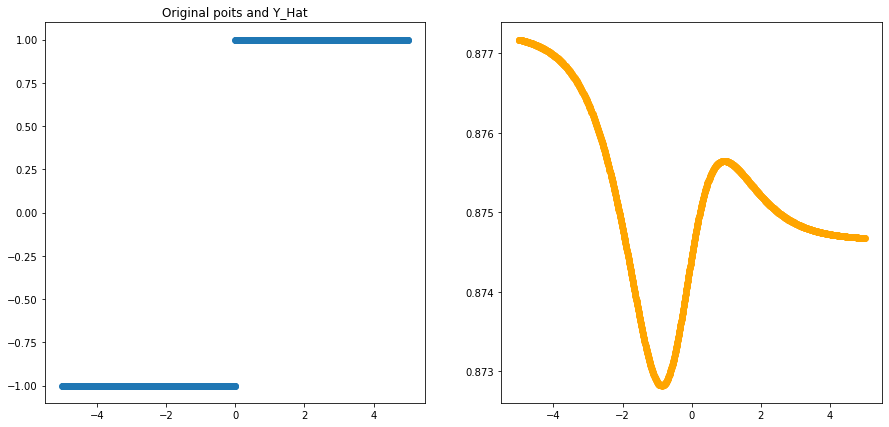

In [19]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,7))
ax1.set_title('Original poits and labels')
ax1.scatter(inputs,labels);

ax1.set_title('Original poits and Y_Hat')
ax2.scatter(inputs,outputs,color='orange');

Note the huge difference in our y-axis! This is **without** and training so its bound to be bad! 

<div class="info">

**Pause-and-ponder**: Go back and re run the network above and re-plot the final representation. Notice how random it is! This is because we initialize with random weights, but never actually do any training! 
    
</div>

## Dealing with Biases

Another very common notational trick people do, as we saw in **linear regression**, was to **add "another dimension"** to "automatically" deal with our **bias**. 

Here,  that means adding **another "node" to each layer**. This node has **no input, only outputs**, and its **activation is always the value 1**.

![](figures/biases.png)

<div class="info">

**Question**: How does this act as a bias?
    
</div>

Well, lets look at what this means for a particular node. Lets once again highlight the orange node:

![](figures/bias-weights.png)

What **effect** does this have for this orange nodes update? Well, lets write out what it is:

![](figures/bias-weights-eqn.png)

So, $\color{orange}{w}_{\color{orange}{0},\color{blue}{3}}$ is **always** being multiplied by the value $1$. This is exactly the role of the bias! 

![](figures/bias-weights-eqn-simp.png)

As we can see, the addition of a constant node in a layer **gives an extra weight to each node in the next layer**. This weight, multiplied by 1, **acts as the bias for each node**. 

So all we have to do, is **add an extra <font color="red">column</font> to each weight matrix** in our network. (Note: often, this bias is omitted from the final layer).

Now, for a layer $L$, the **weight matrix** is of size: $k \times j+1$, where $k$ is the number of *actual*/*real* hidden nodes in layer $L$, and $j$ is the number of *actual/real* hidden nodes in layer $L-1$. 

**Note**: often this is drawn with the bias nodes on top of the others, not below. 
    
![](figures/bias-on-top.png)
    
So we would think of the 0-th weight acting as the bias, so we would add an extra column to the left/right of each weight matrix. Its ultimately the same thing
 

As a sanity check that this works, lets compare the output of the previous implementation with this new notation. To do so, we need to make sure they use the same initialization. Lets take it out of the function and "make it flat" so we can easily compare:

In [20]:
# W and b network
# initialize weight matrices - notice the dimensions
W_1 = np.random.randn(3,1)
W_2 = np.random.randn(2,3)
W_3 = np.random.randn(1,2)

# and our biases
b_1 = np.random.randn(3,1)
b_2 = np.random.randn(2,1)
b_3 = np.random.randn(1,1)

In [21]:
# W network - adding biases to the right:
W_1_b = np.hstack((W_1,b_1))
W_2_b = np.hstack((W_2,b_2))
W_3_b = np.hstack((W_3,b_3))

Lets run the "old network" notation:

In [22]:
# layer 1
a_1_old = sigmoid(W_1.dot(inputs.T) + b_1)

# layer 2
a_2_old = sigmoid(W_2.dot(a_1_old)+b_2)

# output layer
output_old = sigmoid(W_3.dot(a_2_old)+b_3)
output_old = np.squeeze(np.asarray(output_old)).reshape(-1,1)

And now the "new" network notation. Note: in order to run the inputs through, we need to add the "extra dimension of 1's", as we've done many times before!

In [23]:
inputs_new = np.c_[inputs,np.ones(inputs.shape[0])]

Now we can go ahead and "feed it in"

In [24]:
# layer 1
a_1_new = sigmoid(W_1_b.dot(inputs_new.T))
# append the 1 to the end of the previous layers activations:
a_1_new = np.r_[a_1_new, np.ones((1,a_1_new.shape[1]))]

# layer 2
a_2_new = sigmoid(W_2_b.dot(a_1_new))
# append the 1 to the end of the previous layers activations:
a_2_new = np.r_[a_2_new, np.ones((1,a_2_new.shape[1]))]

# output layer
output_new = sigmoid(W_3_b.dot(a_2_new))
output_new = np.squeeze(np.asarray(output_new)).reshape(-1,1)

Lets verify they are both equal:

In [25]:
np.equal(output_new,output_old).all()

True

<div class="info">

**Note**: This might seem like **a strange hack** - We have to reshape each layers weight matrix, and each layers activation matrix to account for this extra "1" flying around everywhere. 

I will not try to convince you one way or the other which makes the most sense. I'm just explaining it here in case it is useful to you to think of the bias as "being wrapped up" in our weight matrix, as it was when we discussed linear regression. 
    
Moving forward, we will **not** be using this notation in the rest of the notebook.

</div>

## Activation Functions

Lets imagine revisiting the previous network structure under different activation functions:

### Linear

Lets start with a **linear activation** function:

In [26]:
def linear(z):
    return z

This is almost always called a linear activation, but is better thought of as the identity activation - that is, it just returns what it was given, unaltered.

What does this mean for the computation our network can perform? 

Once again, lets flatten our implementation to take a look:

In [27]:
inputs,labels = toy()

In [28]:
# initialize weight matrices - notice the dimensions
W_1 = np.random.randn(3,1)
W_2 = np.random.randn(2,3)
W_3 = np.random.randn(1,2)

# and our biases
b_1 = np.random.randn(3,1)
b_2 = np.random.randn(2,1)
b_3 = np.random.randn(1,1)

In [29]:
# layer 1
a_1 = linear(W_1.dot(inputs.T) + b_1)

# layer 2
a_2 = linear(W_2.dot(a_1)+b_2)

# output layer
outputs = linear(W_3.dot(a_2)+b_3)
outputs = np.squeeze(np.asarray(outputs)).reshape(-1,1)

Lets plot it:

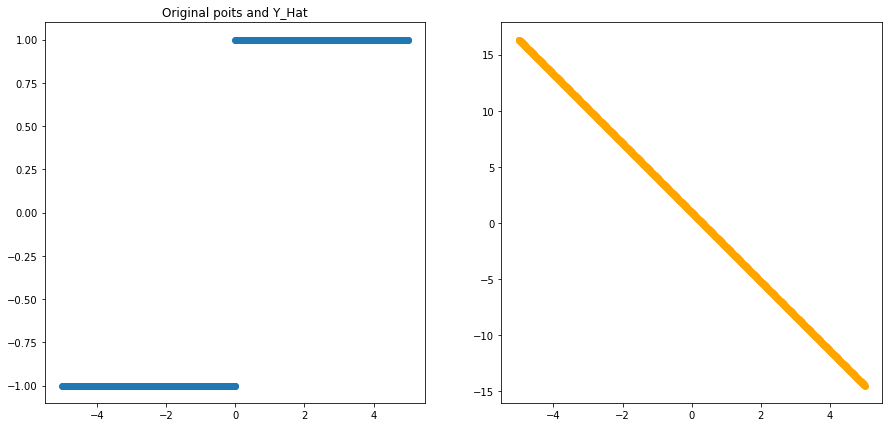

In [30]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,7))
ax1.set_title('Original poits and labels')
ax1.scatter(inputs,labels);

ax1.set_title('Original poits and Y_Hat')
ax2.scatter(inputs,outputs,color='orange');

<div class="info">
    
🧐 **Pause-and-ponder**: Go back and re-run the above a few times. What does this mean?
    
</div>

Remember, what we are visualizing is the inputs and the corresponding output value - what our network has been able to map to.

You might be noticing that this is strangely linear! Indeed! With linear activation functions, all we are able to do is calculate some linear combination of our inputs! 

Lets dig in a bit more, and show what we are actually calculating at Layer $L$:

$$
A^L = W_3((W_2(W_1X^T + b_1) + b_2) + b_3
$$

Well, lets distribute this out:
$$
A^L = W_3W_2W_1X^T + W_3W_2b_1 + W_3b_2 + b_3
$$

Ok, wait a second... this is getting confusing - lets check to make sure the sizes work out! 

![](figures/linear-sizes.png)

<div class="info">

Lets go through this part together in class!

</div>

Ok! We can see that the sizes do in fact work out!


<div class="info">

🧐**Pause-and-ponder:** In your resulting equation, perform some clarifying substitutions. What do we discover? 
    
</div>

After some substitutions, we can write an equation like the following:

$$
\hat{\mathbf{Y}} = \mathbf{W}^*X^T + \mathbf{b}^*
$$

Which tells us that a NN with only linear activations, is ultimately just another linear function of its inputs! It doesn't matter how deep or wide it is! 

### A Final Sigmoid

Given our understanding above, what would happen if we only add a sigmoid at the end? Something like:

![](figures/final-sig.png)

<div class="info">

🧐**Pause-and-ponder**: What do you think it represents? What is its **representational capacity**? 
    
</div>

# Backprop

Now that we have a good idea about **forward propagation** we're ready to learn by **backpropagating an error** signal through the network, allowing us to **attribute** "blame"/"error" to each specific weight/bias in our network. 

In other words, one way to think of what the result of backprop is as a large vector which tells us which parameters are the most responsible for our error - or phrased another way - which ones we should change, and by how much, and in what direction, in order to get the biggest reduction of our error. 

## Latex definitions
This cell just creates some latex definitions we will need later. 
$
\newcommand{\bx}[1]{\color{purple}{b^{#1}}}
\newcommand{\bl}{\color{purple}{b^L}}
\newcommand{\wx}[1]{\color{blue}{w^{#1}}}
\newcommand{\wl}{\color{blue}{w^L}}
\newcommand{\wone}{\color{blue}{w_1}}
\newcommand{\ax}[1]{\color{green}{a^{#1}}}
\newcommand{\al}{\color{green}{a^L}}
\newcommand{\zx}[1]{\color{orange}{z^{#1}}}
\newcommand{\zl}{\color{orange}{z^L}}
\newcommand{\ap}{\color{green}{a^{L-1}}}
\newcommand{\czero}{\color{red}{C_0}}
\newcommand{\dc}{\color{red}{\partial C_0}}
\newcommand{\dw}[1]{\color{blue}{\partial \wx{#1}}}
\newcommand{\dz}[1]{\color{orange}{\partial \zx{#1}}}
\newcommand{\da}[1]{\color{green}{\partial \ax{#1}}}
\newcommand{\db}[1]{\color{purple}{\partial \bx{#1}}}
\newcommand{\dap}{\color{green}{\partial \ax{L-1}}}
\newcommand{\dcdw}[1]{\frac{\dc}{\dw{#1}}}
\newcommand{\dcdz}[1]{\frac{\dc}{\dz{#1}}}
\newcommand{\dzdb}[1]{\frac{\dz{#1}}{\db{#1}}}
\newcommand{\dzdw}[1]{\frac{\dz{#1}}{\dw{#1}}}
\newcommand{\dadz}[1]{\frac{\da{#1}}{\dz{#1}}}
\newcommand{\dcda}[1]{\frac{\dc}{\da{#1}}}
\newcommand{\dcdb}[1]{\frac{\dc}{\db{#1}}}
\newcommand{\dcdap}{\frac{\dc}{\dap}}
\newcommand{\deltal}{\delta^L}
\newcommand{\deltax}[1]{\delta^{#1}}
$
**Note: Make sure you run this cell!**

## 1-D Case

**Note**: This presentation follows **very closely** these two **fantastic** resources
* [3blue1brown - Backpropagation calculus](https://www.youtube.com/watch?v=tIeHLnjs5U8)
* [Michael Nielsen - Neural Networks and Deep Learning - Chapter 2](http://neuralnetworksanddeeplearning.com/chap2.html)

Lets revisit the simplest network we started with at the beginning of this notebook:

![](figures/1d-bp-net.png)

**Notation Note**: we're introducing a new notation $\color{blue}{w_3 = w^L, w_2 = w^{L-1}}, \ldots$ and we will be using them interchangeably. 

To focus our discussion, lets just focus on the last two levels, and label their activation values:

![](figures/1d-bp-end.png)

The output layer defines the "representation" our network has created for a specific input: 

$$
\begin{align}
\zl &= \wl\ap+\bl \\
\al &= \sigma(\zl)
\end{align}
$$

Where now we are using color to denote the *kind* of variable we are talking about. For example, activations for any layer are <font color="green">green</font>.

So, its with this layers activation that we want to measure our **cost**, on a **specific example** $x_0$ run through our network:

$$
\czero = (\al - y)^2
$$

Another way to think about this process, is as this **computational graph**:

![](figures/1d-bp-graph.png)

This tells a "causal" story, about what variables are needed to compute other variables. Note: this could be carried even further back through the network, all the way to the inputs! 

<div class="info">

**Note:** This is a "light weight"/conceptual **computational graph**. Its a way to introduce the concept of backpropagating partial derivatives through a graph using the chain rule. 

</div>

Lets try to understand exactly what a "partial derivative" like $\dcdw{L}$ is telling us, by associating **a little number line** with each of these variables:

![](figures/1d-bp-graph-num-line.png)

Pictorially, this is telling us that a little nudge to a weight, results in a nudge to the "activity"/$\zl$ of the neuron (Q: how big/how small of a nudge?), which then results in a nudge to the activation/$\al$ of the neuron (Q: how big/how small of a nudge?) which then results in a nudge to the total cost of the network (how big/how small of a nudge?).

So conceptually, the partial $\dcdw{L}$ is capturing:

![](figures/1d-bp-dcdw.png)

### Simulation
We actually go ahead and simulate this to better understand what its telling us! Lets start by running an example through our network:

In [31]:
inputs,outputs = toy()
input,output = inputs[0],outputs[0]

In [32]:
# initialize weights
w_1 = np.random.randn()
w_2 = np.random.randn()
w_3 = 1 #exagerating for plotting purposes

# and our biases
b_1 = np.random.randn()
b_2 = np.random.randn()
b_3 = np.random.randn()


# layer 1
z_1 = w_1*input+b_1
a_1 = sigmoid(z_1)

# layer 2
z_2 = w_2*a_1+b_2
a_2 = sigmoid(z_2)

# output layer
z_3 = w_3*a_2+b_3
a_3 = sigmoid(z_3)

In [33]:
cost_0 = (output - a_3)**2

### Nudge $\color{blue}{w^L}$

Now lets give $\wl$ a "little nudge", and see how it propagates through the network! 

**Note**: This is not really a little nudge. Ive greatly exaggerated it to provide a good looking plot.

In [34]:
nudge = np.linspace(-5,5,51)
z_3_nudged = (w_3 + nudge)*a_2 + b_3
a_3_nudged = sigmoid(z_3_nudged)
cost_0_nudged = (a_3_nudged - output)**2

Lets plot it!

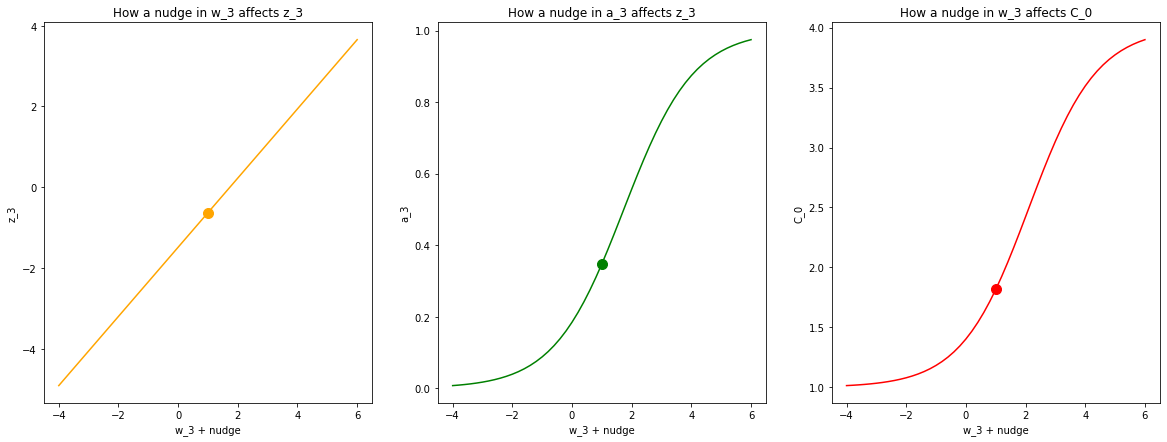

In [35]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20,7),sharex=True)
ax1.plot(w_3+nudge,z_3_nudged,c="orange");
ax1.scatter(w_3,w_3*a_2+b_3,s=100,c='orange');
ax1.set_xlabel('w_3 + nudge');
ax1.set_ylabel('z_3');
ax1.set_title("How a nudge in w_3 affects z_3")

ax2.plot(w_3+nudge, a_3_nudged,c='green');
ax2.scatter(w_3,sigmoid(w_3*a_2+b_3),s=100,c='green');
ax2.set_xlabel('w_3 + nudge');
ax2.set_ylabel('a_3');
ax2.set_title("How a nudge in a_3 affects z_3")

ax3.plot(w_3+nudge, cost_0_nudged,c='red');
ax3.scatter(w_3,(sigmoid(w_3*a_2+b_3)-output)**2,s=100,c='red');
ax3.set_xlabel('w_3 + nudge');
ax3.set_ylabel('C_0');
ax3.set_title("How a nudge in w_3 affects C_0");

What is this telling us? That a little nudge in $w_3$ results in very different changes to each the variables down our computational graph! 

### Nudge $\color{blue}{w_1}$

Lets repeat this simulation, except go **more back/backer** to see how a nudge at $w_1$ affects our output layer and our cost!

In [36]:
nudge = np.linspace(-5,5,51)
z_1_nudged = (w_1 + nudge)*input + b_1
a_1_nudged = sigmoid(z_1_nudged)

z_2_nudged = w_2*a_1_nudged + b_2
a_2_nudged = sigmoid(z_2_nudged)

z_3_nudged = w_3*a_2_nudged + b_3
a_3_nudged = sigmoid(z_3_nudged)

cost_0_nudged = (a_3_nudged - output)**2

Plot it!

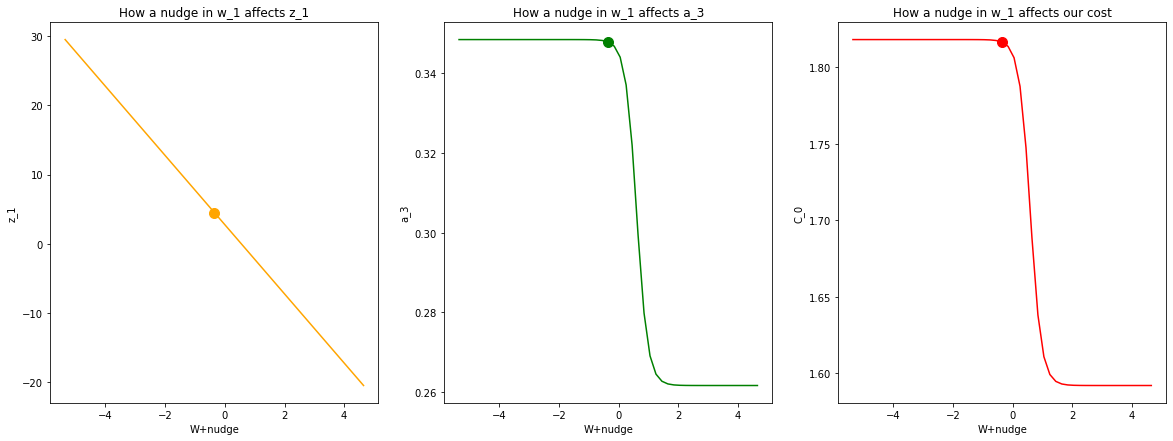

In [37]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20,7),sharex=True)

ax1.plot(w_1+nudge,z_1_nudged,c="orange");
ax1.scatter(w_1,w_1*input+b_1,s=100,c='orange');
ax1.set_xlabel('W+nudge');
ax1.set_ylabel('z_1');
ax1.set_title("How a nudge in w_1 affects z_1")

ax2.plot(w_1+nudge, a_3_nudged,c='green');
ax2.scatter(w_1,sigmoid(w_3*(sigmoid(w_2*sigmoid(w_1*input+b_1)+b_2))+b_3),s=100,c='green');
ax2.set_xlabel('W+nudge');
ax2.set_ylabel('a_3');
ax2.set_title("How a nudge in w_1 affects a_3")

ax3.plot(w_1+nudge, cost_0_nudged,c='red');
ax3.scatter(w_1,(sigmoid(w_3*(sigmoid(w_2*sigmoid(w_1*input+b_1)+b_2))+b_3)-output)**2,s=100,c='red');
ax3.set_xlabel('W+nudge');
ax3.set_ylabel('C_0');
ax3.set_title("How a nudge in w_1 affects our cost");

Ah, these graphs have are a bit more interesting, so we can point out the following:

**Implicit** in all of these graphs are the following idea:

$$
\frac{\text{the amount of change in a dependent variable}}{\text{the amount of change in a variable that it depends on}}
$$

Well, this is just the **rate of change** of the graph! Which we might remember! Lets restate this idea for each subplot:

The specific rate of change for the first subplot is:

$$
\frac{\text{resulting change in }\color{orange}{z_1}}{\text{some amount of change in } \color{blue}{w_1}} = \frac{\color{orange}{\Delta z_1}}{\color{blue}{\Delta w_1}}
$$

The specific rate of change for the second subplot is:

$$
\frac{\text{resulting change in }\color{green}{a_3}}{\text{some amount of change in } \color{blue}{w_1}} = \frac{\color{green}{\Delta a_3}}{\color{blue}{\Delta w_1}}
$$


The specific rate of change for the third subplot is:

$$
\frac{\text{resulting change in } \color{red}{C_0}}{\text{some amount of change in } \color{blue}{w_1}} = \frac{\color{red}{\Delta C_0}}{\color{blue}{\Delta w_1}}
$$



Aha! That last subplot is telling us something about how **sensitive** the cost $\czero$ is to changes in $\wone$. This is what we want! 

We can see that a little change to $\wone$ to the left/right (depends on random vals), results in a big change to our final cost on this example! 

This **rate of change**/**derivative** tells us the direction we need to change $\wone$ in order to reduce our costs!

---
### We could do better

Now, from the plotting code for the last subplot up there you might notice that to generate that last subplot, we basically had to run the entire nudged $\wone + \Delta$ all the way through our entire network!

We are also reasoning about the derivative by looking at a graph, instead of actually calculating it so that we can use it. 

Lets see if we can think of a clever scheme of **actually calculating** our partials with respect to our weights: $\ldots,\dcdw{L-1},\dcdw{L}$, by starting with 

$$
\dcdw{L} = ?
$$

Lets **bring back our computational graph**:

![](figures/1d-bp-graph.png)

Lets use the following idea to **decompose our graph** starting from the end/bottom:

$$
\frac{\text{the amount of change in a dependent variable}}{\text{the amount of change in a variable that it depends on}}
$$

---
Starting at $\czero$, we have:

$$
\dcda{L}
$$

This object tells us how the cost changes with respect to the final layers activation. Lets calculate it:

$$
\begin{align}
\czero &= (\al - y)^2 \\
\dcda{L}  &= 2(\al -y)
\end{align}
$$

What happens if $\al$ is small? Well then it contributes less to our error! 

So we should focus on making sure that when $\al$ is large, its correct!


<div class="info">

🧐**Pause-and-ponder**: What about $\frac{\czero}{\partial y}$ ? What can we say about this?
    
</div>

---
According to our computational graph, thats all of the **immediate** "independent" variables $\czero$ has. So lets now switch our focus to $\al$:

$$
\begin{align}
\al &= \sigma (\zl) \\
\dadz{L} &= \sigma ^{\color{red}{\prime}}(\zl)
\end{align}
$$

where $\sigma^{\color{red}{\prime}}(\cdot)$ is the *derivative* of our sigmoid activation function:

$$
\sigma^{\color{red}{\prime}}(\cdot) = \sigma(\cdot)(1-\sigma(\cdot))
$$

This lets us rewrite the above as:

$$
\begin{align}
\dadz{L} &= \sigma(\zl)(1-\sigma(\zl))
\end{align}
$$

---

We now have the following partials:

$$
\begin{align}
\dcda{L} &: \text{how changing } \al \text{ changes } \czero \\ \\
\dadz{L} &: \text{how changing } \zl \text{ changes } \al
\end{align}
$$

It shouldn't require too much convincing that we can **multiply** these two objects together to create a new partial:

$$
\begin{align}
\dcda{L} \cdot \dadz{L} &= \dcdz{L} \\
                        &= \text{how changing } \zl \text{ changes } \czero
\end{align}
$$

Indeed, the notation itself suggests this by allowing us to "cancel out" partials that appear on top and on bottom:


<div style="text-align:center">
<img src="figures/dcdz.png">
</div>

The last step is to actually write this out to get an expression for $\dcdz{L}$:

$$
\begin{align}
\dcdz{L} &= \dadz{L} \cdot \dcda{L} \\
         &= \underbrace{\sigma(\zl)(1-\sigma(\zl))}_{\text{how changing }\zl\text{ affects }\al} \cdot  \underbrace{2(\al -y)}_{\text{how changing }\al\text{ affects }\czero}
\end{align}
$$

<div class="info">

🧐**Pause-and-ponder**: We have just discovered and applied the **chain rule**! We have used it to **backpropagate** a change at the output of our last layer: $\dcda{L}$, to a change at the input of the activation function of our last layer: $\dadz{L}$.

</div>

<div class="info">
    
📖**Semi-Definition**: **Backpropagation** can be thought of as applying the chain rule **back** across our computational graph!
    
</div>

---
### Lets keep going!

So far we've backpropagated once. Lets look at our map so far:

![](figures/1d-bp-graph-current.png)

Lets keep **backpropagating** (chain-ruling)! We can now look at the inputs $\zl$ has. Lets focus on one of the most interesting for right now, $\wl$:

$$
\begin{align}
\zl &= \wl\ax{L-1}+\bl \\
\dzdw{L} &= \ax{L-1}
\end{align}
$$

<div class="info">

🧐**Pause-and-ponder**: This derivative has a particularly interesting interpretation. Its saying that the amount a nudge to our weight in the last layer influences the "activity" of the last layer, depends on how strong the previous neuron was firing! In other words, if the previous neuron was very active, even a small nudge could cause big changes! But if the previous neuron was always low activation/low firing, then this weight doesn't really matter!
    
**Note:** This observation is often stated as:
    
* "Neurons that fire together, wire together",
* "Weights between low activation neurons learn very slowly"

</div>

With this, we can **chain it** together with our other partials to write an expression for $\dcdw{L}$:

$$
\begin{align}
\dcdw{L} &= \dzdw{L}\dcdz{L}\\ \\
         &= \dzdw{L}\dadz{L}\dcda{L} \\ \\
         &= \underbrace{\ax{L-1}}_{\text{how changing }\wl\text{ affects } \zl} \quad \underbrace{\sigma(\zl)(1-\sigma(\zl))}_{\text{how changing }\zl\text{ affects }\al} \quad \underbrace{2(\al -y)}_{\text{how changing }\al\text{ affects }\czero}
\end{align}
$$

Or simply:

$$
\begin{align}
\dcdw{L} &= \dzdw{L}\dadz{L}\dcda{L} \\ 
         &= \left(\ax{L-1}\right) \left(\sigma(\zl)(1-\sigma(\zl))\right) \left(2(\al -y)\right)
\end{align}
$$

<div class="info">

🧐**Pause-and-ponder**: From here, can you guess the appropriate equation for $\dcdb{L}$? 
    
**Hint**:
    
$$
\frac{\dc}{?} = \frac{\dz{L}}{?}\dadz{L}\dcda{L}
$$
    
</div>

---
Wow! We've come a long way! We finally have an actual expression for how a change to **one of our weights** ($\wl$) causes a change to our cost **for a single example**.

![](figures/1d-bp-graph-wl.png)

Lets finish up by using the **hint** I gave above 
    
$$
\frac{\dc}{?} = \frac{\dz{L}}{?}\dadz{L}\dcda{L}
$$

to find an expression for how the cost changes with respect to the **previous layers activity** $\dcda{L-1}$:

$$
\dcda{L-1} = \underbrace{\frac{\dz{L}}{\da{L-1}}}_{\text{need to calculate}}\underbrace{\dadz{L}\dcda{L}}_{\text{already have this}}
$$

So all we need is an expression for $\frac{\dz{L}}{\da{L-1}}$:

$$
\begin{align}
\zl &= \wl\ax{L-1}+\bl \\ 
\frac{\dz{L}}{\da{L-1}} &= \wl
\end{align}
$$

Letting us write:

$$
\dcda{L-1} = \left(\wl\right) \left(\sigma(\zl)(1-\sigma(\zl))\right) \left(2(\al -y)\right)
$$

For completion, and as an answer to a previous pause-and-ponder, lets write out the expression for $\dcdb{L}$:

$$
\dcdb{L} = \dzdb{L}\dadz{L}\dcda{L}
$$

We can get an expression for $\dzdb{L}$:

$$
\begin{align}
\zl      &= \wl\ax{L-1}+\bl \\
\dzdb{L} &= 1
\end{align}
$$

And so
$$
\begin{align}
\dcdb{L} &= 1\cdot\dadz{L}\dcda{L}\\
         &= \left(\sigma(\zl)(1-\sigma(\zl))\right) \left(2(\al -y)\right)
\end{align}
$$

Lets group this level all together to write all partials for this level:

$$
\begin{align}
\dcdw{L}   &= \left(\ax{L-1}\right) &&\cdot&\left(\sigma(\zl)(1-\sigma(\zl))\right) \left(2(\al -y)\right) \\
\dcdb{L}   &= 1 &&\cdot&\left(\sigma(\zl)(1-\sigma(\zl))\right) \left(2(\al -y)\right) \\
\dcda{L-1} &=\left(\wl\right) &&\cdot&\left(\sigma(\zl)(1-\sigma(\zl))\right) \left(2(\al -y)\right)
\end{align}
$$

---
### Speaking of Error...
Aha! We can notice they all have something in common: 

$$
\dcdz{L}=\dadz{L}\dcda{L}
$$

<div class="info">

**Definition**: The **error** associated with layer $L$ is given by:
    
$$
\deltal = \dcdz{L}=\dadz{L}\dcda{L}
$$
    
often stated simply as:
    
$$
\deltal = \dcdz{L}
$$
    
and completely as:
    
$$
\begin{align}
\deltal &= \sigma(\zl)(1-\sigma(\zl)) (\al -y) \\
        &= \sigma^{\color{red}{\prime}}(\zl) (\al-y)
\end{align}
$$

**Note:** We've discarded that $2$ from the cost as is often done.
    
</div>

<div class="info">

🧐**Pause-and-ponder**: Why is this called the error?
    
</div>

This lets rewrite our partials as:

$$
\begin{align}
\dcdw{L}   &= \ax{L-1} \deltal \\
\dcdb{L}   &= \deltal \\
\dcda{L-1} &= \wl \deltal
\end{align}
$$

---
### What about the rest?

And thats it! We've **finally** finished out how our cost function changes with respect to one layer: $L$. But we've only done one layer! Not to worry! We've discovered backpropagation and the chain rule! So the rest is easy! 

Lets look at our map

![](figures/1d-bp-map-lminus1.png)

We've boxed in what we know how to do so far. This also tells us its very straight forward to now give the equations for layer $L-1$:

$$
\begin{align}
\dcdw{L-1} &= \dzdw{L-1} \dadz{L-1} \dcda{L-1} \\
\dcdb{L-1} &= \dzdb{L-1} \dadz{L-1} \dcda{L-1} \\
\dcda{L-2} &= \frac{\dz{L-1}}{\da{L-2}} \dadz{L-1} \dcda{L-1}
\end{align}
$$

---
### Fully recursive definition 
Wow! We again see they have something in common!

<div class="info">

**Definition**: The error for layer $L-1$ is:
    
$$
\deltax{L-1} = \dcdz{L-1}=\dadz{L-1}\dcda{L-1}
$$
    
often stated simply as:
    
$$
\deltax{L-1} = \dcdz{L-1}
$$
    
</div>

We can now restate the above as:

$$
\begin{align}
\dcdw{L-1} &= \ax{L-2} \deltax{L-1} \\
\dcdb{L-1} &=  \deltax{L-1} \\
\dcda{L-2} &= \wx{L-1} \deltax{L-1}
\end{align}
$$


That is a **recursive definition** that serves for the rest of the graph!

---
### But wait...

Theres more! Lets bring back the definitions of error for layer $L-1$, and the partials for layer $L$:

Partials at layer $L$:

$$
\begin{align}
\dcdw{L}   &= \ax{L-1} \deltal \\
\dcdb{L}   &= \deltal \\
\dcda{L-1} &= \wl \deltal
\end{align}
$$

Error at layer $L-1$:

$$
\deltax{L-1} = \dcdz{L-1}=\dadz{L-1}\dcda{L-1}
$$

Aha! We see something in common again! 

$$
\boxed{\dcda{L-1} = \wl \deltal}
$$

$$
\deltax{L-1} = \dcdz{L-1}=\dadz{L-1}\boxed{\dcda{L-1}}
$$

Lets sub that in and write:

$$
\deltax{L-1} = \dcdz{L-1}=\dadz{L-1}\wl \deltal
$$

We've discovered another **major equation!**:

<div class="info">

📖 **Definition**: The error at **any** layer $L-1$ can be written as a function of the **next layer** $L$:
    
$$
\deltax{L-1} = \wl \deltal \cdot \sigma^{\color{red}{\prime}}(\zx{L-1})
$$
    
</div>

For example, for layer $L-2$:

$$
\begin{align}
\deltax{L-2} &= \wx{L-1}\deltax{L-1}\sigma^{\color{red}{\prime}}(\zx{L-2}) \\
             &= \wx{L-1}\left[  \wl \deltal \cdot \sigma^{\color{red}{\prime}}(\zx{L-1}) \right]\sigma^{\color{red}{\prime}}(\zx{L-2})
\end{align}
$$

---
### The Four Fundamental Backpropagation Equations™

We did it! We've completed backprop on this simple 1D network!

![](figures/1d-bp-net.png)

Lets cap this off by rewriting **scalar versions** of the four fundamental backpropagation equations:

<div class="info">
    
**📖Definition**: **Scalar** versions of the **Four Fundamental Backpropagation Equations™** are given by:
    
$$
\begin{align}
\delta^L &= (\al-y) \cdot \sigma^{\color{red}{\prime}}(\zl)  \tag{BP1} \\
\deltax{\ell} &= \wx{l+1} \delta^{\ell+1} \cdot \sigma^{\color{red}{\prime}}(\zx{\ell}) \tag{BP2} \\
\dcdb{\ell} &= \delta^{\ell} \tag{BP3} \\
\dcdw{\ell} &= \ax{\ell-1}\delta^{\ell} \tag{BP4}
\end{align}
$$
    
where $\ell$ is any layer.

</div>



Some explanation of each:

* BP1 defines the error for the **last layer**. This is the first thing we calculate to perform backprop.
* BP2 defines the error for **any layer** $\ell$ in terms of the error at the next level $\ell+1$. 
* BP3 defines the bias update at **any layer** $\ell$
* BP4 defines the weight update at **any layer** $\ell$

BP2 and BP4 have **interesting interpretations** which will become more salient when we get to matrices/vectors, but that we can first describe here:

---
Lets start with BP2:

$$
\deltax{\ell} = \wx{l+1} \delta^{\ell+1} \cdot \sigma^{\color{red}{\prime}}(\zx{\ell})
$$

We can think of this as **the** backprop equation, as it clearly captures the backward flow of errors from outputs back through the network! 

You can also think of BP2 as saying the following: Just as $\wx{\ell+1}$ acted on the **activation** of the **previous** layer $\ax{l}$ to **bring it forward** to the current layer, it acts on the **error** of the **current layer** to **bring it back** to the previous layer! 
 
**Note:** This will become a bit more intutive when we get to matrices, as we will see this equation will have a weight matrix in the forward direction, and a **transpose** in the reverse direction

---
Lets rewrite BP4 as:

$$
\dcdw{} = \color{green}{a_{in}}\delta_{out}
$$


where it's understood that $\color{green}{a_{in}}$ is the activation of the neuron input to the weight $w$, and $\delta_{out}$ is the **error** of the neuron output from the weight $w$.

Clearly, when $\color{green}{a_{in}}$ is small, then $\dcdw{}$ is small. This is another way to say that this weight **learns slowly**, meaning that it's not changing much during gradient descent. In other words, one consequence of BP4 is that weights output from low-activation neurons learn slowly.

<div class="info">

🧐**Pause-and-ponder**: What else can we say? Think about what these equations are telling us! 
    
</div>

### Implementation

We're now ready to go ahead and implement backprop ourselves! 

<div class="info">

💪🏽**Exercise**: Implement this procedure on our toy example!
    
</div>

In [38]:
def backprop_1d():
    # EDIT HERE
    return

<div class="info">

🧐**Pause-and-ponder**: Once we've implemented these equations and calculated our partials all the way back through our network, what do we do?! 
    
</div>

## Multidimensional case


Now things are going to get **interesting**! In our simple toy example, we only had one neuron per layer. This means in our resulting equations everything was just scalar values. 

### Latex definitions
This cell contains more latex definitions. $
\newcommand{\j}{{j}}
\newcommand{\k}{{k}}
\newcommand{\wjkl}{\color{blue}{w_{\j,\k}^L}}
\newcommand{\ajl}{\color{green}{a_j^L}}
\newcommand{\ajx}[1]{\color{green}{a_j^{#1}}}
\newcommand{\akx}[1]{\color{green}{a_k^{#1}}}
\newcommand{\zjl}{\color{orange}{z_j^L}}
\newcommand{\va}{\color{green}{\mathbf{a}}}
\newcommand{\vy}{\mathbf{y}}
\newcommand{\vz}{\color{orange}{\mathbf{z}}}
\newcommand{\dwjkl}{\color{blue}{\partial w_{\j,\k}^L}}
\newcommand{\dcdwjk}{\frac{\dc}{\dwjkl}}
\newcommand{\dzjdwjk}{\frac{\color{orange}{\partial z_j^L}}{\dwjkl}}
\newcommand{\dajdzj}{\frac{\color{green}{\partial \ajl}}{\color{orange}{\partial z_j^L}}}
\newcommand{\dcdaj}{\frac{\dc}{\color{green}{\partial \ajl}}}
\newcommand{\dcdakx}[1]{\frac{\dc}{\color{green}{\partial \akx{#1}}}}
$**Note**: remember to run it!

### Notation

Now, we have to be a bit more careful! Lets remind ourselves of the notation we used above:

![](figures/nd-net.png)

Here, we've labeled each neuron by its activation, layer number, and number in layer. For example, $\ajl$ is neuron $\j$, in layer $L$, and $\wjkl$ is the weight that connects neuron $\k$ in layer $L-1$ to neuron $\j$ in layer $L$.

Now, the **cost** of a single example $\czero$ is a sum over the activations of all neurons in the last layer:

$$
\czero = \frac{1}{2}\sum_{\j} (\ajl - y_{\j})^2
$$

which in vector notation is:

$$
\czero = \frac{1}{2}\|\va^L - \vy\|^2
$$

Before going into vector/matrix notation, lets still deal with an **individual weight** in this network: $\wjkl$, and write out our backprop equation for this single weight:

$$
\dcdwjk = \dzjdwjk \dajdzj \dcdaj
$$

For completion, lets write expressions for each of its pieces.

For $\dcdaj$:

$$
\begin{align}
\czero &= \frac{1}{2}\sum_{\j} (\ajl - y_{\j})^2 \\
\dcdaj &= (\ajl - y_j)
\end{align}
$$

For $\dajdzj$:
$$
\begin{align}
\dajdzj = \sigma(\zjl)(1-\zjl)
\end{align}
$$

For $\dzjdwjk$:
$$
\begin{align}
\zjl     &= \ldots + \wjkl \color{green}{a_k^{L-1}} + \ldots \\
\dzjdwjk & =  \color{green}{a_k^{L-1}}
\end{align}
$$

**Note:** Pay particular attention to the $k$ index in the equation above! Remember, our weights are applied to the activations of the previous layer, which we are using $k$ to index!

Just as we did above, we can define a **neuron specific error measure** for neuron $j$ in layer $L$ as:

$$
\begin{align}
\delta_{j}^L &= \frac{\dc}{\color{orange}{\partial}\zjl} \\
             &= \dajdzj \dcdaj \\
             &= \sigma(\zjl)\sigma(1-\zjl) (\ajl - y_j)
\end{align}
$$

**Note**: pay particular attention to the $j$ index above! This is with respect to the current layer, which we are using $j$ to index!

This lets us rewrite the above as:

$$
\dcdwjk = \color{green}{a_k^{L-1}} \delta_{j}^L
$$

Above we've given the equation for how the cost changes with a specific weight in our multi dimensional network. Notice how close it is to the 1D case! 

<div class="info">
    
💪🏽**Exercise**: Give the equation for $\frac{\dc}{\color{purple}{\partial b^L_j}}$
    
</div>

Now, lets look at $\dcdakx{L-1}$. This is asking how the cost varies when we change the activation of a neuron $k$ in layer $L-1$. 

Just using pattern matching, we might **want** to write:

$$
\dcdakx{L-1} \stackrel{\color{red}{?}}{=} \wjkl \delta_j^L
$$

But **this is incorrect!** To see why, lets draw a picture showing how nueron $k$ in layer $L-1$ affects the current layer (and therefore the cost):

![](figures/2d-ak.png)


Aha! The activation of neuron $k$ in layer $L-1: \akx{L-1}$ does **not** just flow through neuron $j$ in layer $L$, it flows through **every single neuron in layer $L$!**

So if we want to account for the effect a small nudge to this neuron's activation value has on our cost, we need to account for **each neuron in layer $L$**, and each associated weight! 

Our correct equation is then:

$$
\dcdakx{L-1} = \sum_j \left[ \wjkl \delta_j^L \right]
$$


### Implementation

Ok! We've gone to the multidimensional case, but still given equations for each individual parameter. So really, its almost exactly as it was in the 1D case!

<div class="info">
    
💪🏽**Exercise**: Implement the backprop equations above! 

</div>

As a hint, some **pseudo-code** for the implementation would be:

```
# skipping setup
# skipping forward pass

for sample in inputs:
    # last layer
    for neuron_j in layer[-1].neurons:
        delta_j = # calculate according to formula above
        dc_dwj = # calculate according to formula above
        dc_dbj = # calculate according to formula above
        dc_dak^{L-1} = # calculate according to formula above
    
    # other layers
    for layer in layers-1:
        for neuron_j in layer[l].neurons:
            delta_j = # calculate according to formula above
            dc_dwj = # calculate according to formula above
            dc_dbj = # calculate according to formula above
            dc_dak^{L-1} = # calculate according to formula above
    
```

## N-D Revisited - Vector Notation

Above, we gave specific equations for each parameter in a multi dimensional network. This will work, as your implementation should prove! 

However, it leaves much to be desired in terms of efficiency, and conciseness, and it doesn't allow us to make full use of the magic of our numerical linear algebra libraries! 

Lets begin our analysis with our error vector $\delta_{j}^L$:

$$
\begin{align}
\delta_{j}^L &= \frac{\dc}{\color{orange}{\partial}\zjl} \\
             &= \dajdzj \dcdaj \\
             &= \sigma(\zjl)\sigma(1-\zjl) (\ajl - y_j) \\
             &= \sigma^{\color{red}{\prime}}(\zjl) (\ajl - y_j)
\end{align}
$$
where we brought back the $\sigma^{\color{red}{\prime}}(\cdot)$ notation.


We would like to write a **vector** for our error $\delta^L$, where each component is:

$$
\delta^L = \begin{bmatrix}
\sigma^{\color{red}{\prime}}(\color{orange}{z_1^L}) (\color{green}{a_1^L} - y_1) \\
\cdots \\
\sigma^{\color{red}{\prime}}(\zjl) (\color{green}{a_j^L} - y_j)\\
\cdots
\end{bmatrix}
$$

This is exactly the definition of element-wise product of the following vectors: $\color{orange}{\mathbf{z}^L},\color{green}{\mathbf{a}^L}$ and $\vy$:

$$
\delta^L = \sigma^{\color{red}{\prime}}(\color{orange}{\mathbf{z}^L}) \odot (\color{green}{\mathbf{a}^L} - \vy)
$$

where we introduce another piece of notation:

<div class="info">

📖**Definition**: The **Hadamard product** between two vectors is the element-wise product:
    
$$
\mathbf{a} \odot \mathbf{b} = 
\begin{bmatrix}
a_1 \cdot b_1 \\
\cdots \\
a_n \cdot b_n
\end{bmatrix}
$$
    
</div>

Lets define a **function** to implement this element-wise product:

In [39]:
def hadamard(a,b):
    result = np.zeros_like(a)
    for i in range(a.shape[0]):
        result[i] = a[i] * b[i]
    
    return result

Lets test it!

In [40]:
a,b = np.random.randint(1,10,(3,1)),np.random.randint(1,10,(3,1))
a,b

(array([[6],
        [4],
        [9]]),
 array([[8],
        [3],
        [5]]))

In [41]:
hadamard(a,b)

array([[48],
       [12],
       [45]])

It works! 

**However**, Python actually already does this element-wise product for us! Using the `*` operator!

In [42]:
a*b

array([[48],
       [12],
       [45]])

So we didn't have to implement our own. But thats ok, because we know how to.  Lets get back to business! 

We've rewritten BP1 in vector notation. Lets now focus on BP2: **moving the error "backward"**.

Well, we can probably already guess its going to involve the hadamard product with $\sigma^{\color{red}{\prime}}(\cdot)$ as it did previously. We just don't know with what yet! 

$$
\begin{align}
\delta^\ell = ?? \odot \sigma^{\color{red}{\prime}}(\mathbf{\zx{\ell}})
\end{align}
$$

Well, lets try to reason through it from "first principles" (**recall**: this means **make the sizes work!**).

$\delta^\ell$ is a vector, which should be of size $k$, the number of elements in layer $\ell$. We know its going to be formed with the **weight matrix** and $\delta^{\ell+1}$, so lets write their sizes:

$$
W^{\ell+1}: (j \times k), \quad\quad \delta^{\ell+1}: (j \times 1)
$$

How do we multiply these out to get a vector of size $k \times 1$ out?

🧐

Indeed! We need to **transpose** our weight matrix, and then take the usual matrix-vector product with $\delta^{\ell+1}$! 

Now we can write the vectorized equation for the error at any layer:

<div class="info">

📖**Vectorized BP2**: The error at **any** layer $\ell$ can be written as as function of the next layer as:

$$
\delta^{\ell} = (W^{\ell+1})^T \delta^{\ell+1} \odot \sigma^{\color{red}{\prime}}(\mathbf{\zx{\ell}})
$$

</div>



<div class="info">

🧐**Pause-and-ponder**: What can we say about our previous interpretation in light of this new equation? 
    
</div>

Lets quickly tackle BP3:


<div class="info">

📖**Vectorized-BP3**: 

$$
\frac{\dc}{\color{purple}{\partial \mathbf{b}^\ell}} = \delta^\ell
$$

</div>

Well, that was easy! Its just as it was above, but as a vector. 

Hm. Now we get to the tough one: **BP4**. This is now a partial derivative of our cost **with respect to weight matrix**! 

Lets start at the last layer. $\color{blue}{W^L}$ is of size $j \times k$, where $j$ is the size of the last layer. 

So, its we should expect its **gradient** to be of the same size: a matrix. If its not clear why, just imagine how were going to use this partial. We're going to add it the current value of $\color{blue}{W}$ in gradient descent, so it better be of the same size!

To form this matrix, we have $\color{green}{\mathbf{a}^{L-1}}$, which is of size $k \times 1$, the size of the previous layer, and $\delta^L$, which is of size $j \times 1$. 

So how do we form this matrix using these two vectors? We take the **outer product**:

$$
\delta^L(\color{green}{\mathbf{a}^{L-1}})^T
$$

Lets make sure the sizes work! 

$$
(j \times 1)(1 \times k) = (j \times k)
$$

Perfect! 

<div class="info">

📖**Vectorized BP4**: 
    
$$
\frac{\dc}{ \color{blue}{ \partial \mathbf{W^\ell} } } = \delta^L(\color{green}{\mathbf{a}^{L-1}})^T
$$
    
</div>



Finally! Lets give fully vectorized forms of the batchprop equations:

---
### F.F.B.E - Vectorized™

Lets cap this off by writing **vectorized versions** of the four fundamental backpropagation equations:

<div class="info">
    
**📖Definition**: **Vectorized** versions of the **Four Fundamental Backpropagation Equations™** are given by:
    
$$
\begin{align}
\delta^L &= (\color{green}{\mathbf{a}^L} - \vy)  \odot  \sigma^{\color{red}{\prime}}(\color{orange}{\mathbf{z}^L}) \tag{BP1}\\
\delta^{\ell} &= (\color{blue}{W^{\ell+1}})^T \delta^{\ell+1} \odot \sigma^{\color{red}{\prime}}(\mathbf{\zx{\ell}})\tag{BP2} \\
\frac{\dc}{\color{purple}{\partial \mathbf{b}^\ell}} &= \delta^\ell \tag{BP3} \\
\frac{\dc}{ \color{blue}{ \partial \mathbf{W^\ell} } } &= \delta^\ell(\color{green}{\mathbf{a}^{\ell-1}})^T \tag{BP4}
\end{align}
$$

</div>

---
### Implementation

Wow! Now we've really come a long way!

<div class="info">
    
💪🏽**Exercise**: Implement the backprop equations above! 

</div>

As you're implementing this, think about the following:
<div class="info">
    
🧐**Pause-and-ponder**: How do you deal with multiple samples? 
    
</div>

## Fully vectorized implementation

This implementation follows the details of: 
* http://ufldl.stanford.edu/tutorial/supervised/MultiLayerNeuralNetworks/
* https://www.youtube.com/watch?v=GlcnxUlrtek&list=PLiaHhY2iBX9hdHaRr6b7XevZtgZRa1PoU&index=4&pbjreload=101
* https://github.com/stephencwelch/Neural-Networks-Demystified/blob/master/Part%202%20Forward%20Propagation.ipynb
* https://www.youtube.com/watch?v=7bLEWDZng_M&list=PLkDaE6sCZn6Ec-XTbcX1uRg2_u4xOEky0&index=33
* https://www.youtube.com/watch?v=gl3lfL-g5mA

## Additional Resources:

* https://news.ycombinator.com/item?id=15782156
* https://developers-dot-devsite-v2-prod.appspot.com/machine-learning/crash-course/backprop-scroll